# Marginal Value Theorem
A place to test experimental parameters for foraging behavior in line with the marginal value theorem.

## Initial setup

In [11]:
import sys
sys.path.insert(0, '../python')

In [50]:
import numpy as np
from helper import get_optimal_values
import matplotlib.pyplot as plt

In [39]:
from importlib import reload
reload(helper)

<module 'helper' from '../python\\helper.py'>

## Fit environment to behavior
Given preferred patch residence and travel times, what is the environment in which such behavior is optimal?

In [65]:
# Behavior parameters (fixed)
t_p = 30
t_t = 10

# Environment parameters (varied)
R_0 = np.array([0.0])
r_0 = np.arange(10, 501, 50)/100
tau = np.zeros([R_0.shape[0], r_0.shape[0]])
r_opt = np.zeros([R_0.shape[0], r_0.shape[0]])
for i, R_0_ in enumerate(R_0):
    tau[i, :], r_opt[i, :] = get_optimal_values(t_p=t_p, t_t=t_t, R_0=R_0_, r_0=r_0)

C:\Users\Mcginley_Lab\Anaconda3\lib\site-packages\scipy\optimize\nonlin.py:1000: RuntimeWarning: invalid value encountered in true_divide
  d = v / vdot(df, v)


Text(0.5,1,'t_p=30, t_t=10, R_0=0')

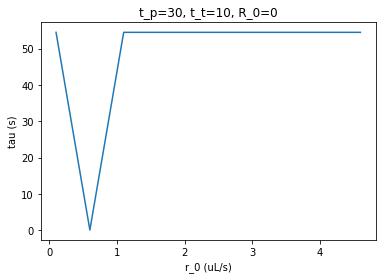

In [66]:
plt.plot(r_0, tau[0, :])
plt.xlabel('r_0 (uL/s)')
plt.ylabel('tau (s)')
plt.title('t_p=%d, t_t=%d, R_0=%d' % (t_p, t_t, R_0[0]))

In [53]:
r_0

array([1.])

In [ ]:
# Remember, R_0 / r_0 must be ≥ t_t, otherwise R_0 will default to zero!

## Fit behavior to environment
Given environmental parameters, what is optimum behavior?

In [15]:
[t_p, t_t, r_0] = [np.asarray(kwarg) if kwarg is not None else None for kwarg in [t_p, t_t, r_0]]

In [4]:
max([0.0, 1.0, 5])

5